<a href="https://colab.research.google.com/github/troveski/Tracking-/blob/main/C%C3%B3pia_de_causal_tapir_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<p align="center">
  <h1 align="center">TAPIR: Tracking Any Point with per-frame Initialization and temporal Refinement</h1>
  <p align="center">
    <a href="http://www.carldoersch.com/">Carl Doersch</a>
    ·
    <a href="https://yangyi02.github.io/">Yi Yang</a>
    ·
    <a href="https://scholar.google.com/citations?user=Jvi_XPAAAAAJ">Mel Vecerik</a>
    ·
    <a href="https://scholar.google.com/citations?user=cnbENAEAAAAJ">Dilara Gokay</a>
    ·
    <a href="https://www.robots.ox.ac.uk/~ankush/">Ankush Gupta</a>
    ·
    <a href="http://people.csail.mit.edu/yusuf/">Yusuf Aytar</a>
    ·
    <a href="https://scholar.google.co.uk/citations?user=IUZ-7_cAAAAJ">Joao Carreira</a>
    ·
    <a href="https://www.robots.ox.ac.uk/~az/">Andrew Zisserman</a>
  </p>
  <h3 align="center"><a href="https://arxiv.org/abs/2306.08637">Paper</a> | <a href="https://deepmind-tapir.github.io">Project Page</a> | <a href="https://github.com/deepmind/tapnet">GitHub</a> | <a href="https://github.com/deepmind/tapnet/tree/main#running-tapir-locally">Live Demo</a> </h3>
  <div align="center"></div>
</p>

<p align="center">
  <a href="">
    <img src="https://storage.googleapis.com/dm-tapnet/swaying_gif.gif" alt="Logo" width="50%">
  </a>
</p>

In [3]:
# @title Download Code {form-width: "25%"}
!git clone https://github.com/deepmind/tapnet.git

Cloning into 'tapnet'...
remote: Enumerating objects: 618, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 618 (delta 175), reused 208 (delta 159), pack-reused 327
Receiving objects: 100% (618/618), 1.28 MiB | 19.87 MiB/s, done.
Resolving deltas: 100% (365/365), done.


In [4]:
# @title Install Dependencies {form-width: "25%"}
!pip install -r tapnet/requirements_inference.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.1 MB/s eta 0:00:00
  Created wheel for jaxline: filename=jaxline-0.0.8-py3-none-any.whl size=37760 sha256=e099ac7f841e0255eedc89266ebeb25418c420b686ed4dd573d08024ab0b46f4
  Stored in directory: /root/.cache/pip/wheels/19/d6/75/04b2a65170bebc8e51d3aceb16d526339fd5ac5eed7ef75469
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94505 sha256=b1196b54b8ccc65b9356ffe3da3fa6b3933fd01513b084a6b7bca4e857910bd9
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built jaxline ml_collections


In [5]:
# @title Download Model {form-width: "25%"}

%mkdir tapnet/checkpoints

!wget -P tapnet/checkpoints https://storage.googleapis.com/dm-tapnet/causal_tapir_checkpoint.npy

%ls tapnet/checkpoints

--2023-12-24 00:23:51--  https://storage.googleapis.com/dm-tapnet/causal_tapir_checkpoint.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127043639 (121M) [application/octet-stream]
Saving to: ‘tapnet/checkpoints/causal_tapir_checkpoint.npy’

causal_tapir_checkp 100%[===================>] 121.16M  18.9MB/s    in 7.8s    

2023-12-24 00:24:00 (15.5 MB/s) - ‘tapnet/checkpoints/causal_tapir_checkpoint.npy’ saved [127043639/127043639]

causal_tapir_checkpoint.npy


In [6]:
# @title Imports {form-width: "25%"}
%matplotlib widget
import functools

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from tqdm import tqdm
import tree

from tapnet import tapir_model
from tapnet.utils import transforms
from tapnet.utils import viz_utils

from google.colab import output
output.enable_custom_widget_manager()

In [7]:
# @title Load Checkpoint {form-width: "25%"}

checkpoint_path = 'tapnet/checkpoints/causal_tapir_checkpoint.npy'
ckpt_state = np.load(checkpoint_path, allow_pickle=True).item()
params, state = ckpt_state['params'], ckpt_state['state']

In [8]:
# @title Build Model {form-width: "25%"}

# Internally, the tapir model has three stages of processing: computing
# image features (get_feature_grids), extracting features for each query point
# (get_query_features), and estimating trajectories given query features and
# the feature grids where we want to track (estimate_trajectories).  For
# tracking online, we need extract query features on the first frame only, and
# then call estimate_trajectories on one frame at a time.

def build_online_model_init(frames, query_points):
  """Initialize query features for the query points."""
  model = tapir_model.TAPIR(use_causal_conv=True, bilinear_interp_with_depthwise_conv=False)

  feature_grids = model.get_feature_grids(frames, is_training=False)
  query_features = model.get_query_features(
      frames,
      is_training=False,
      query_points=query_points,
      feature_grids=feature_grids,
  )
  return query_features


def build_online_model_predict(frames, query_features, causal_context):
  """Compute point tracks and occlusions given frames and query points."""
  model = tapir_model.TAPIR(use_causal_conv=True, bilinear_interp_with_depthwise_conv=False)
  feature_grids = model.get_feature_grids(frames, is_training=False)
  trajectories = model.estimate_trajectories(
      frames.shape[-3:-1],
      is_training=False,
      feature_grids=feature_grids,
      query_features=query_features,
      query_points_in_video=None,
      query_chunk_size=64,
      causal_context=causal_context,
      get_causal_context=True,
  )
  causal_context = trajectories['causal_context']
  del trajectories['causal_context']
  return {k: v[-1] for k, v in trajectories.items()}, causal_context


online_init = hk.transform_with_state(build_online_model_init)
online_init_apply = jax.jit(online_init.apply)

online_predict = hk.transform_with_state(build_online_model_predict)
online_predict_apply = jax.jit(online_predict.apply)

rng = jax.random.PRNGKey(42)
online_init_apply = functools.partial(
    online_init_apply, params=params, state=state, rng=rng
)
online_predict_apply = functools.partial(
    online_predict_apply, params=params, state=state, rng=rng
)

In [9]:
# @title Utility Functions {form-width: "25%"}

def preprocess_frames(frames):
  """Preprocess frames to model inputs.

  Args:
    frames: [num_frames, height, width, 3], [0, 255], np.uint8

  Returns:
    frames: [num_frames, height, width, 3], [-1, 1], np.float32
  """
  frames = frames.astype(np.float32)
  frames = frames / 255 * 2 - 1
  return frames


def postprocess_occlusions(occlusions, expected_dist):
  """Postprocess occlusions to boolean visible flag.

  Args:
    occlusions: [num_points, num_frames], [-inf, inf], np.float32

  Returns:
    visibles: [num_points, num_frames], bool
  """
  pred_occ = jax.nn.sigmoid(occlusions)
  pred_occ = 1 - (1 - pred_occ) * (1 - jax.nn.sigmoid(expected_dist))
  visibles = pred_occ < 0.5  # threshold
  return visibles


def sample_random_points(frame_max_idx, height, width, num_points):
  """Sample random points with (time, height, width) order."""
  y = np.random.randint(0, height, (num_points, 1))
  x = np.random.randint(0, width, (num_points, 1))
  t = np.random.randint(0, frame_max_idx + 1, (num_points, 1))
  points = np.concatenate((t, y, x), axis=-1).astype(np.int32)  # [num_points, 3]
  return points


def construct_initial_causal_state(num_points, num_resolutions):
  value_shapes = {
      "tapir/~/pips_mlp_mixer/block_1_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_1_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_2_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_2_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_3_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_3_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_4_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_4_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_5_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_5_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_6_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_6_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_7_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_7_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_8_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_8_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_9_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_9_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_10_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_10_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_11_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_11_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_causal_2": (1, num_points, 2, 2048),
  }
  fake_ret = {
      k: jnp.zeros(v, dtype=jnp.float32) for k, v in value_shapes.items()
  }
  return [fake_ret] * num_resolutions * 4

In [ ]:
###########################################################################################################################

In [10]:
from google.colab import files

uploaded = files.upload()


Saving multimeter_img.png to multimeter_img.png
Saving test_multimeter.mp4 to test_multimeter.mp4


In [9]:
%mkdir tapnet/examplar_videos

In [2]:
ls


sample_data/


In [11]:
# @title Load an Exemplar Video {form-width: "25%"}


video = media.read_video('test_multimeter.mp4')
height, width = video.shape[1:3]
#media.show_video(video, fps=30)

In [ ]:
# @title Load an Exemplar Video {form-width: "25%"} NAOOOOOO PRECISOOOO

%mkdir tapnet/examplar_videos

!wget -P tapnet/examplar_videos https://storage.googleapis.com/dm-tapnet/horsejump-high.mp4

video = media.read_video('tapnet/examplar_videos/horsejump-high.mp4')
height, width = video.shape[1:3]
media.show_video(video, fps=10)

In [ ]:
# @title SOTA* - For bounding boxes


import cv2  # For reading the image
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for Colab

# Load your image using OpenCV (or any other library you prefer)
image_path = 'multimeter_img.png'  # Replace with your image path
image_data = cv2.imread(image_path)
image_data = cv2.resize(image_data, (256, 256))


# Define a function to get the center point from an image
def get_center_point(image):
    center_x = image.shape[1] // 1.9
    center_y = image.shape[0] // 1.2
    center_t = 0  # Assuming a single image (no time dimension)
    return np.array([[center_t, center_y, center_x]], dtype=np.int32)

# Use the function to get the center point
center_point = get_center_point(image_data)

# Rest of your code that uses center_point
resize_height = 256
resize_width = 256

# Assuming the 'media' module and other functions are defined elsewhere in your code
frames = media.resize_video(video, (resize_height, resize_width))
query_points = center_point

# Visualize query_points
for point in query_points:
    print(f"Query Point: {point}")

######## PROCESSING VIDEO ######### (BEGGING OF THE BLACK BOX)

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)


# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)


########### SHOW RESULTS ########## (FINAL OF THE BLACK BOX)

# Normalizar os pontos para uma faixa de 0 a 1
normalized_points = tracks / np.array([[resize_width, resize_height]])
print("Normalized Points:")
for frame_idx in range(len(normalized_points)):
    points_in_frame = normalized_points[frame_idx]
    print(f"Frame {frame_idx} - Points: {points_in_frame}")





# Assuming 'normalized_points' is available

# Initialize an empty list to store bounding box coordinates for each frame
bounding_boxes_yolo = []

# Calculate bounding box coordinates for each frame
for frame_idx in range(len(normalized_points)):
    points_in_frame = normalized_points[frame_idx]
    frame_boxes = []

    # Convert normalized coordinates back to image size
    points_in_frame *= np.array([resize_width, resize_height])

    for point in points_in_frame:
        # Define bounding box parameters (adjust these values as needed)
        box_size = 40

        # Convert floating point coordinates to integers
        x, y = map(int, point)
        center_x, center_y = x / resize_width, y / resize_height
        box_width, box_height = box_size / resize_width, box_size / resize_height

        # Calculate bounding box coordinates in YOLOv7 format
        box_x = round(center_x - (box_width / 2), 6)
        box_y = round(center_y - (box_height / 2), 6)

        # Append bounding box coordinates for the frame to the list
        frame_boxes.append([box_x, box_y, round(box_width, 6), round(box_height, 6)])

    # Append bounding box coordinates for the frame to the list
    bounding_boxes_yolo.append(frame_boxes)

# Display the list of bounding box coordinates in YOLOv7 format for each frame
for frame_idx, boxes_in_frame in enumerate(bounding_boxes_yolo):
    print(f"Frame {frame_idx} - Bounding Boxes in YOLOv7 format:")
    for idx, box_coords in enumerate(boxes_in_frame):
        print(f"Box {idx + 1}: {box_coords}")
    print()


# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
media.show_video(video_viz, fps=10)



In [70]:
import cv2
import numpy as np

# Rest of your code...

# Assuming 'video_viz' contains the video to be displayed and saved

# Define the codec and create a VideoWriter object
output_path = 'output_video.mp4'  # Replace with your desired output path
fps = 10  # Frames per second
height, width, _ = video_viz[0].shape  # Get height and width from the video frames
fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # Codec for MP4 format
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Display the video and save it frame by frame
for frame in video_viz:
    # Convert frame to BGR if it's in RGB format
    if frame.shape[2] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # Write the frame to the output video file
    out.write(frame)

# Release the VideoWriter object and close any open windows
out.release()
cv2.destroyAllWindows()

# Print a message indicating successful video saving
print(f"Video saved successfully at: {output_path}")


Video saved successfully at: output_video.mp4


In [75]:
video_visu = media.read_video('output_video.mp4')
height, width = video.shape[1:3]
media.show_video(video_visu, fps=10)



In [1]:
import cv2
from google.colab.patches import cv2_imshow

# Assuming 'video_visu' contains the video frames
video_path = 'output_video.mp4'  # Replace with your video file path
video_visu = cv2.VideoCapture(video_path)

# Specify the frame index you want to visualize
frame_index_to_visualize = 55  # Replace with the desired frame index

# Set the frame position to the desired index
video_visu.set(cv2.CAP_PROP_POS_FRAMES, frame_index_to_visualize)

# Read the frame at the specified index
ret, frame = video_visu.read()

# Check if the frame is read successfully
if ret:
    # Display the frame using cv2_imshow (for Colab)
    cv2_imshow(frame)
else:
    print(f"Error reading frame {frame_index_to_visualize}")

# Release the video capture object
video_visu.release()


Error reading frame 55


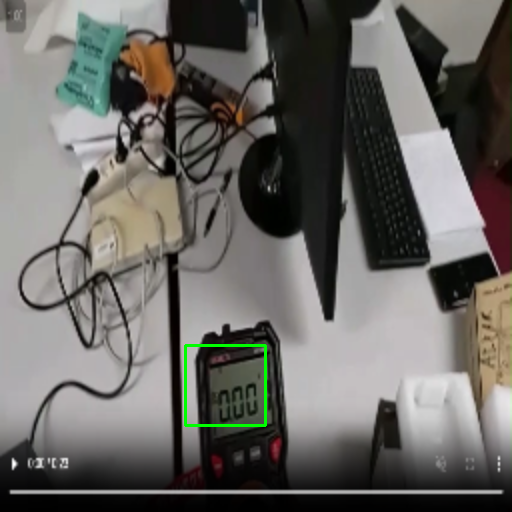

True

In [55]:
# @title Visualize the first bounding box

import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for Colab

# Assuming 'image_data' and 'bounding_boxes_yolo' are available

# Define a function to draw a bounding box on the image
def draw_box(image, box):
    img_copy = np.copy(image)  # Create a copy of the image

    # Convert YOLOv7 format back to pixel coordinates based on the image dimensions
    center_x = int(box[0] * image.shape[1])
    center_y = int(box[1] * image.shape[0])
    box_width = int(box[2] * image.shape[1])
    box_height = int(box[3] * image.shape[0])

    # Calculate box coordinates
    top_left = (center_x - box_width // 2, center_y - box_height // 2)
    bottom_right = (center_x + box_width // 2, center_y + box_height // 2)

    # Draw bounding box on the image
    box_color = (0, 255, 0)  # Green color
    box_thickness = 2
    cv2.rectangle(img_copy, top_left, bottom_right, box_color, box_thickness)

    return img_copy

# Define the dimensions for displaying the image
new_width = int(image_data.shape[1] * 2)
new_height = int(image_data.shape[0] * 2)
resized_image = cv2.resize(image_data, (new_width, new_height))

# Extract the bounding box for the first frame
first_frame_box = bounding_boxes_yolo[0][0]  # Extracting the first box from the first frame

# Draw the box on the first frame
img_with_first_box = draw_box(resized_image, first_frame_box)

# Show and save the image with the bounding box in the first frame
cv2_imshow(img_with_first_box)
cv2.imwrite('bounding_box_first_frame.png', img_with_first_box)  # Save the image



Frame


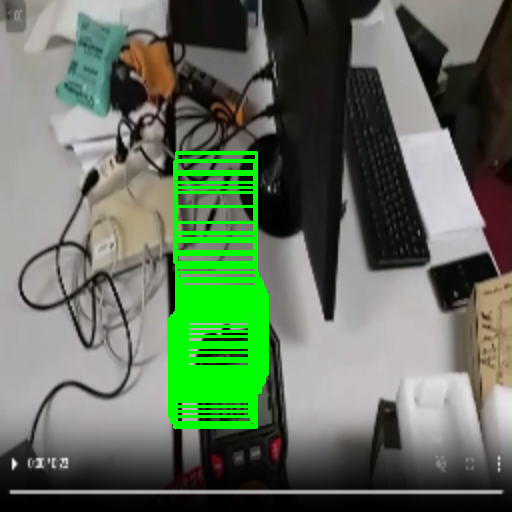

Frame


In [47]:
# @title SOTA - Visualization of the all bounding boxes

import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for Colab

# Assuming 'image_data' and 'bounding_boxes_yolo' are available

# Define a function to draw bounding boxes on the resized image
def draw_boxes(image, boxes):
    img_copy = np.copy(image)  # Create a copy of the resized image

    for box in boxes:
        # Convert YOLOv7 format back to pixel coordinates based on the resized image dimensions
        center_x = int(box[0] * new_width)
        center_y = int(box[1] * new_height)
        box_width = int(box[2] * new_width)
        box_height = int(box[3] * new_height)

        # Calculate box coordinates
        top_left = (center_x - box_width // 2, center_y - box_height // 2)
        bottom_right = (center_x + box_width // 2, center_y + box_height // 2)

        # Draw bounding box on the image
        box_color = (0, 255, 0)  # Green color
        box_thickness = 2
        cv2.rectangle(img_copy, top_left, bottom_right, box_color, box_thickness)

    return img_copy

# Define the new dimensions for displaying the image
new_width = int(image_data.shape[1] * 2)
new_height = int(image_data.shape[0] * 2)
resized_image = cv2.resize(image_data, (new_width, new_height))

# Display images with bounding boxes
for frame_idx, boxes_in_frame in enumerate(bounding_boxes_yolo):
    img_with_boxes = draw_boxes(resized_image, boxes_in_frame)
    cv2_imshow(img_with_boxes)



In [ ]:
# @title Get points from images a grid - SOTA

import cv2  # For reading the image
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for Colab

# Load your image using OpenCV (or any other library you prefer)
image_path = 'multimeter_img.png'  # Replace with your image path
image_data = cv2.imread(image_path)
image_data = cv2.resize(image_data, (256, 256))


# Define a function to get the center point from an image
def get_center_point(image):
    center_x = image.shape[1] // 2
    center_y = image.shape[0] // 1.2
    center_t = 0  # Assuming a single image (no time dimension)
    return np.array([[center_t, center_y, center_x]], dtype=np.int32)

# Define a function to generate multiple points in a grid pattern
def generate_grid_points(image, rows=3, cols=3):
    points = []
    height, width = image.shape[:2]

    for i in range(rows):
        for j in range(cols):
            y = int((i + 1) * height / (rows + 1))
            x = int((j + 1) * width / (cols + 1))
            points.append([0, y, x])

    return np.array(points, dtype=np.int32)

# Use the function to get the center point
center_point = generate_grid_points(image_data)

# Rest of your code that uses center_point
resize_height = 256
resize_width = 256

# Assuming the 'media' module and other functions are defined elsewhere in your code
frames = media.resize_video(video, (resize_height, resize_width))
query_points = center_point

# Visualize query_points
for point in query_points:
    print(f"Query Point: {point}")

######## PROCESSING VIDEO ######### (BEGGING OF THE BLACK BOX)

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)


# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)


########### SHOW RESULTS ########## (FINAL OF THE BLACK BOX)

# Normalizar os pontos para uma faixa de 0 a 1
normalized_points = tracks / np.array([[resize_width, resize_height]])
print("Normalized Points:")
for frame_idx in range(len(normalized_points)):
    points_in_frame = normalized_points[frame_idx]
    #print(f"Frame {frame_idx} - Points: {points_in_frame}") ### Eu comentei esta secção não escrever tudo



# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
media.show_video(video_viz, fps=10)

In [ ]:
# GET resolution

import cv2

# Replace 'path_to_your_video_file.mp4' with the actual path to your video file
video_path = 'test_multimeter.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the resolution (width and height) of the video
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video resolution: {width} x {height}")

# Release the video capture object
cap.release()

Video resolution: 1280 x 720


In [ ]:
# @title Get points from first frame middle - SOTA


def sample_center_point(height, width):
    center_x = width // 2
    center_y = height // 1.2
    center_t = 0  # Considering the first frame
    center_point = np.array([[center_t, center_y, center_x]], dtype=np.int32)
    return center_point


resize_height = 256
resize_width = 256

frames = media.resize_video(video, (resize_height, resize_width))
query_points = sample_center_point(frames.shape[1], frames.shape[2])



query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)


# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
media.show_video(video_viz, fps=10)


In [ ]:
# @title Progressively Predict Sparse Point Tracks - RANDOM   {form-width: "25%"}

resize_height = 256  # @param {type: "integer"}
resize_width = 256  # @param {type: "integer"}
num_points = 1  # @param {type: "integer"}

frames = media.resize_video(video, (resize_height, resize_width))
query_points = sample_random_points(0, frames.shape[1], frames.shape[2], num_points)

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)


# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
media.show_video(video_viz, fps=10)

In [ ]:
# @title Select Any Points at First Frame {form-width: "25%"}

# Generate a colormap with 20 points, no need to change unless select more than 20 points
colormap = viz_utils.get_colors(20)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(video[0])
ax.axis('off')
ax.set_title('You can select more than 1 points. After select enough points, run the next cell.')

select_points = []

 # Event handler for mouse clicks
def on_click(event):
  if event.button == 1 and event.inaxes == ax:  # Left mouse button clicked
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))

    select_points.append(np.array([x, y]))

    color = colormap[len(select_points) - 1]
    color = tuple(np.array(color) / 255.0)
    ax.plot(x, y, 'o', color=color, markersize=5)
    plt.draw()

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

In [ ]:
# @title Predict Point Tracks for the Selected Points {form-width: "25%"}

resize_height = 256  # @param {type: "integer"}
resize_width = 256  # @param {type: "integer"}

def convert_select_points_to_query_points(frame, points):
  """Convert select points to query points.

  Args:
    points: [num_points, 2], [t, y, x]
  Returns:
    query_points: [num_points, 3], [t, y, x]
  """
  points = np.stack(points)
  query_points = np.zeros(shape=(points.shape[0], 3), dtype=np.float32)
  query_points[:, 0] = frame
  query_points[:, 1] = points[:, 1]
  query_points[:, 2] = points[:, 0]
  return query_points

frames = media.resize_video(video, (resize_height, resize_width))
query_points = convert_select_points_to_query_points(0, select_points)
query_points = transforms.convert_grid_coordinates(
    query_points, (1, height, width), (1, resize_height, resize_width), coordinate_format='tyx')

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)

# Predict point tracks frame by frame
predictions = []
for i in tqdm(range(frames.shape[0])):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles, colormap)
media.show_video(video_viz, fps=20)

In [74]:
# @title Donwload a Video

import imageio

# Defina a localização do arquivo de saída
output_path = 'output_video.mp4'

# Salve o vídeo usando imageio
# Certifique-se de 'video_viz' ser um array numpy válido representando o vídeo
imageio.mimsave(output_path, video_viz)

# Baixe o vídeo
files.download(output_path)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

That's it
